In [54]:
import os
# get the binary images

sourceFolder = "image-data"
binaryFiles = []
for filename in os.listdir(sourceFolder):
    if 'binarized' in filename: binaryFiles.append(filename)


In [121]:
import cv2
import numpy as np

def connected_components(thresholded_img):
    im_height, im_width = thresholded_img.shape
    print(thresholded_img.shape)
    bounding_boxes = []
    BB_centers = []

    contours, hierarchy = cv2.findContours(thresholded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # filter out small or invalid bounding boxes
    for j, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if w >= im_width or h >= im_height:
            continue
        # these are artifacts
        if (w < 20 or h < 30):
            continue

        # sometimes parts of characters are picked out as well, control these to change what gets detected
        contour_area = cv2.contourArea(contour)
        contour_perimeter = cv2.arcLength(contour, True)
        contour_compactness = (4 * np.pi * contour_area) / (contour_perimeter ** 2)
            
        # set appropriate threshold values for area and compactness
        # min_area_threshold = 50
        max_compactness_threshold = 0.4
        #if contour_compactness > max_compactness_threshold:
        #    continue

        # 2px border for legibility
        # use max() and min() to prevent the BB going off the sides of the image
        padding = 5
        y1 = max(0, y-padding)
        y2 = min(y+h+padding, im_height)
        x1 = max(0, x-padding)
        x2 = min(x+w+padding, im_width)


        if h > 200:
            print([x1,y1,x2,y2])
            #continue
            cutout = thresholded_img.copy()[y1:y2, x1:x2]
            midline = int((y2-y1)/2)
            cutout[midline - 2 : midline + 3, :] = 0

            [x_adjust, y_adjust] = [x1, y1]

            cutoutBBs, cutoutCenters = connected_components(cutout) # recursive functions are our friends :) espeically if they only recurse once

            for bb, center in zip(cutoutBBs, cutoutCenters):
                print(center)
                [x,y] = center
                center = [x+x_adjust, y+y_adjust]
                BB_centers.append(center)

                [x1,y1,x2,y2] = bb
                bb = [x1+x_adjust, y1+y_adjust, x2+x_adjust, y2+y_adjust]
                bounding_boxes.append(bb)


        elif (y2-y1) > 0 and (x2-x1) > 0:
            BB_centers.append([int(x1+w/2),int(y1+h/2)])
            bounding_boxes.append( [x1,y1,x2,y2] )
    #print(max(heights))


    return bounding_boxes, BB_centers

### the segmentation function
is copied from segmentFunction.py at the moment, but can be played with here to see the immediate results below

In [122]:
import numpy as np
import cv2

def get_circular_kernel(diameter):
    mid = (diameter - 1) / 2
    distances = np.indices((diameter, diameter)) - np.array([mid, mid])[:, None, None]
    kernel = ((np.linalg.norm(distances, axis=0) - mid) <= 0).astype(np.uint8)
    return kernel


def segment_dss_page_PLAY(image):

    bounding_boxes = []
    BB_centers = []
    
    image = cv2.bitwise_not(image)

    kernel = get_circular_kernel(3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,5))
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

    blurred = cv2.GaussianBlur(closed, (3, 5), 0.5)

    thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    kernel = get_circular_kernel(6)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,3))
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_ERODE, kernel, iterations=1)

    final_img = thresholded.copy()
    #thresholded = cv2.bitwise_not(thresholded)
    #ret, labels = cv2.connectedComponents(thresholded, 8)
    #inverted_thresholded = cv2.bitwise_not(thresholded)

    bounding_boxes, BB_centers = connected_components(thresholded)
    

    return bounding_boxes, BB_centers, final_img

(1894, 2021)
(1894, 2021)
[895, 752, 977, 974]
(222, 82)
[51, 160]
[36, 52]


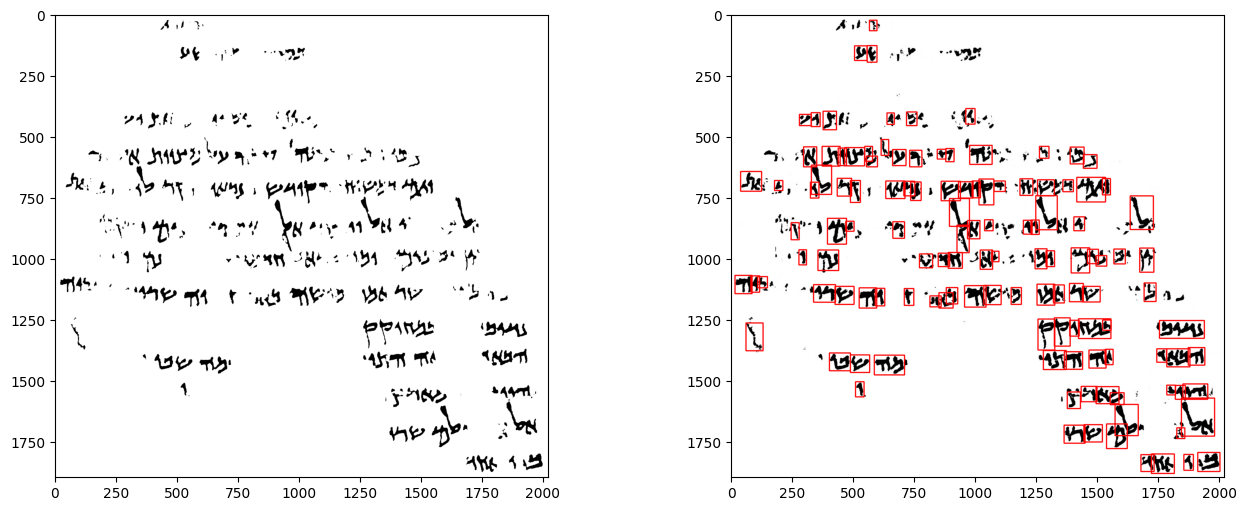

<Figure size 700x700 with 0 Axes>

(1958, 2595)
(1958, 2595)
[1986, 580, 2102, 793]
(213, 116)
[100, 183]
[35, 153]
[53, 49]


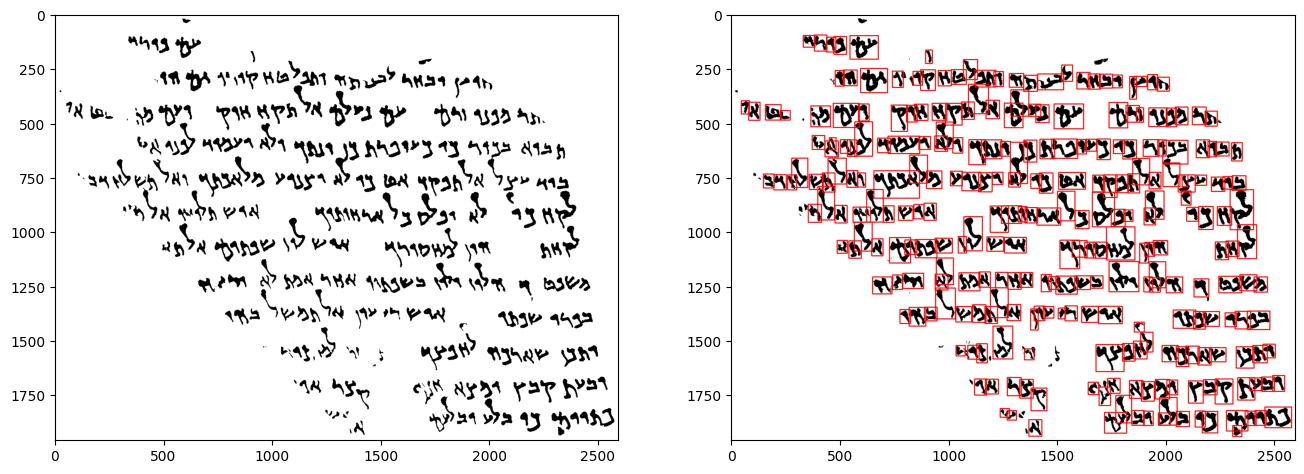

<Figure size 700x700 with 0 Axes>

(1732, 2617)
(1732, 2617)
[654, 300, 757, 512]
(212, 103)
[42, 153]
[63, 49]


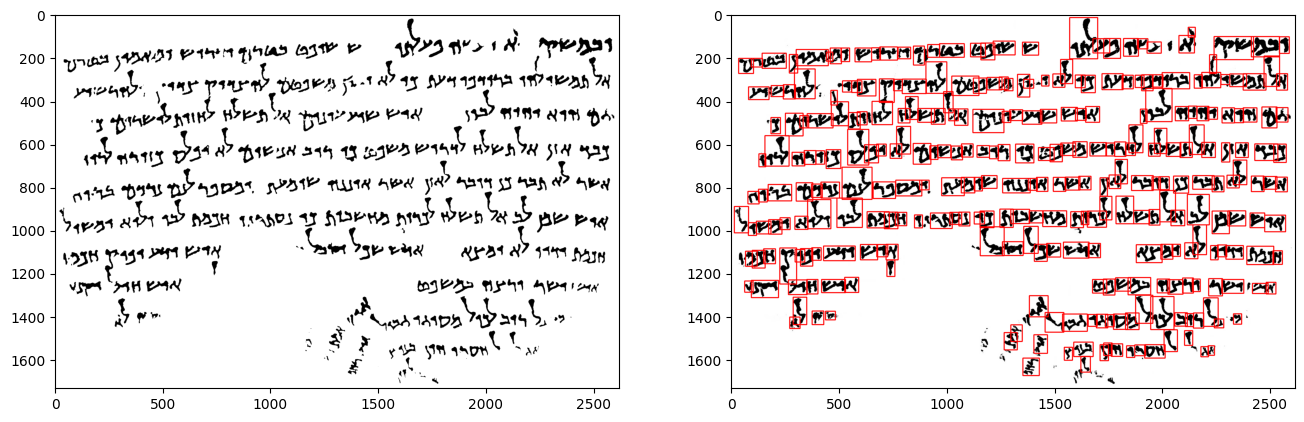

<Figure size 700x700 with 0 Axes>

(1344, 977)
(1344, 977)


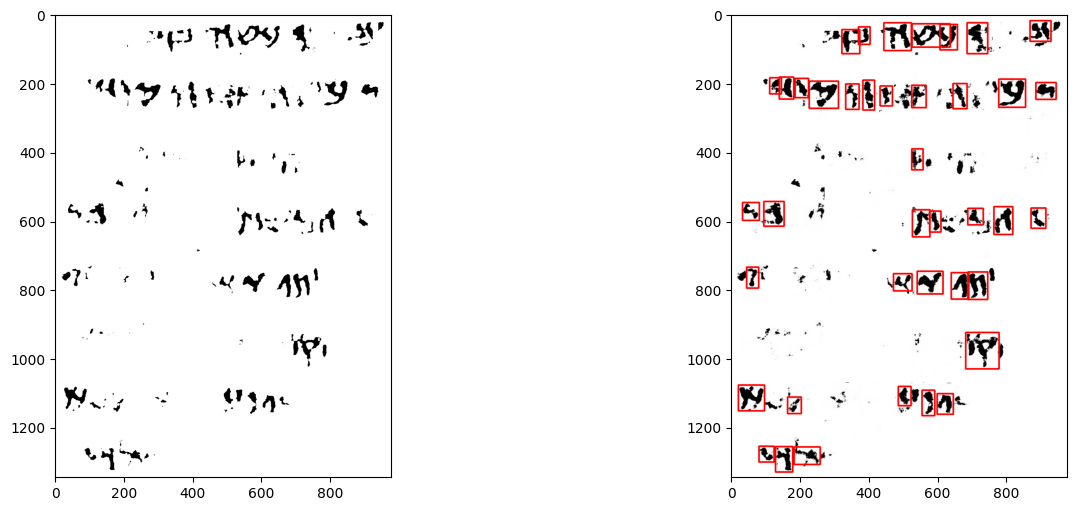

<Figure size 700x700 with 0 Axes>

(2055, 722)
(2055, 722)


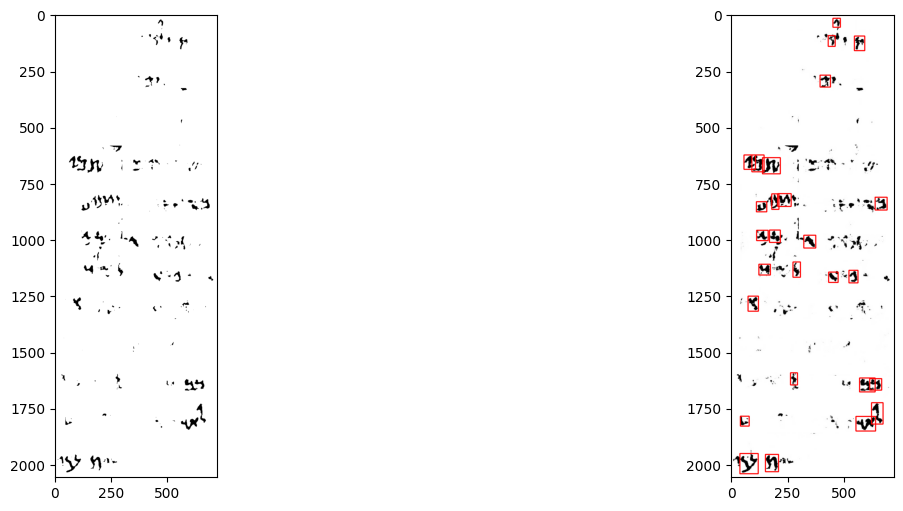

<Figure size 700x700 with 0 Axes>

(1412, 1279)
(1412, 1279)


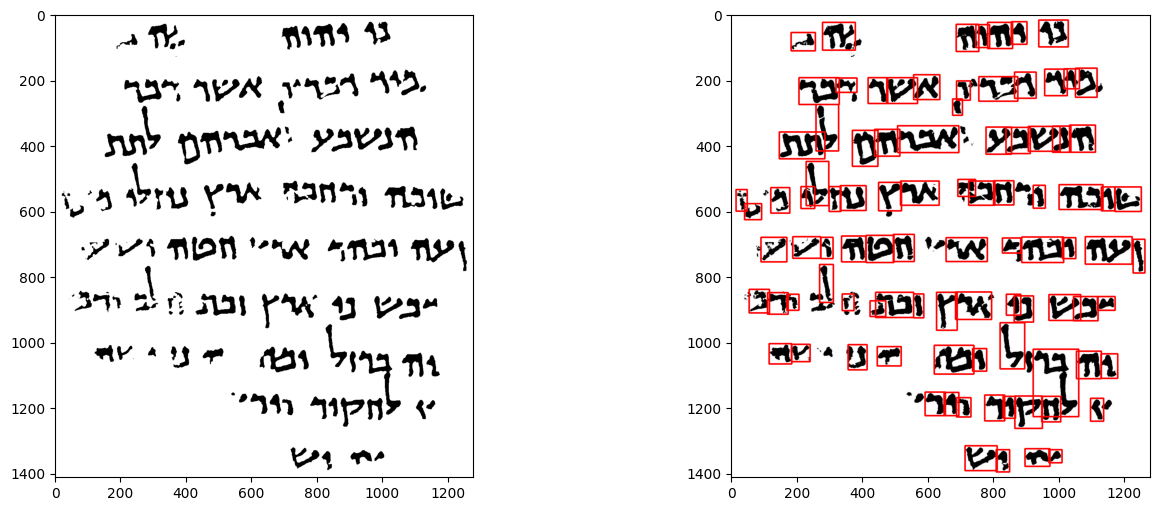

<Figure size 700x700 with 0 Axes>

(1566, 1189)
(1566, 1189)
[330, 291, 425, 504]
(213, 95)
[20, 176]
[54, 153]
[42, 49]
[653, 113, 789, 361]
(248, 136)
[70, 180]
[42, 58]


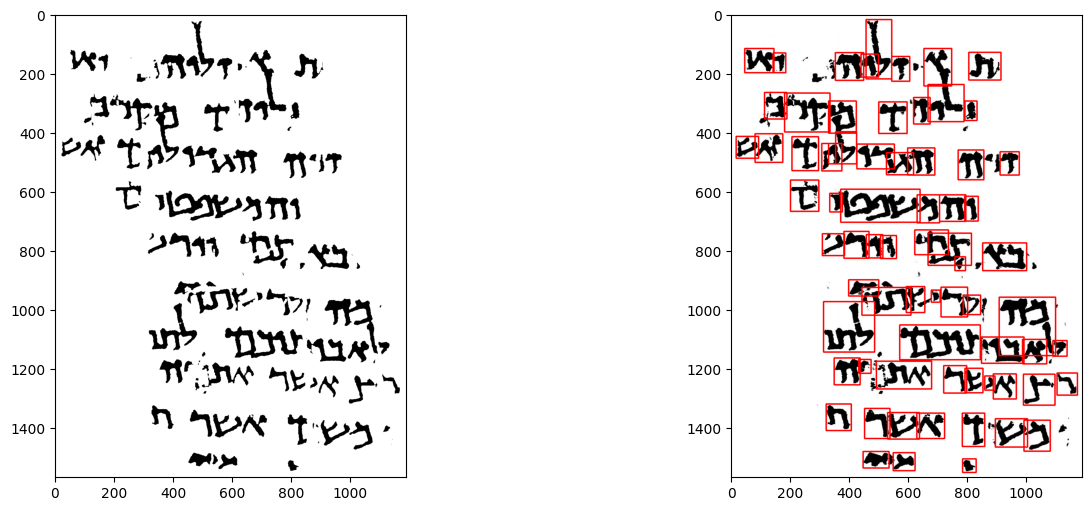

<Figure size 700x700 with 0 Axes>

(1592, 1253)
(1592, 1253)


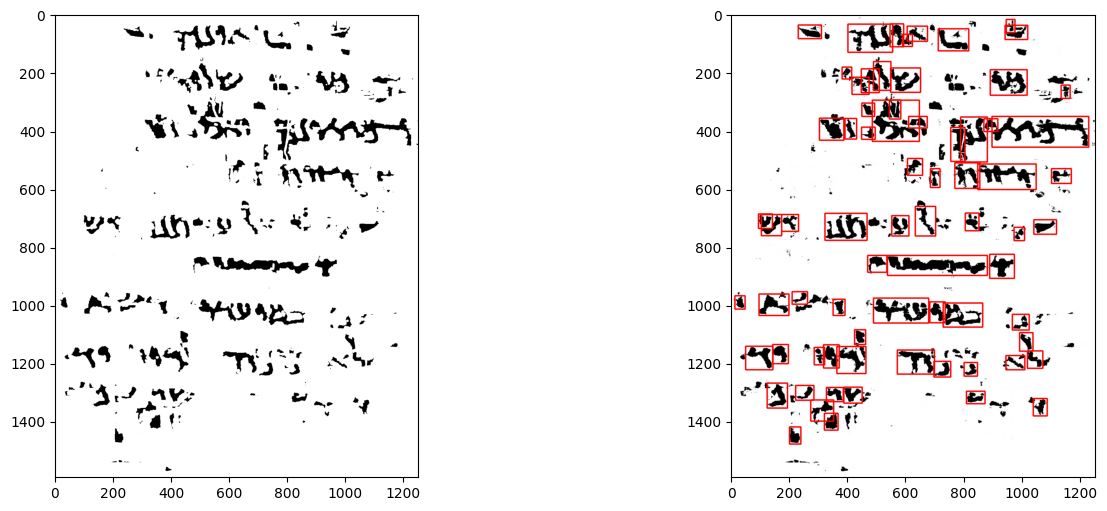

<Figure size 700x700 with 0 Axes>

(1325, 1397)
(1325, 1397)


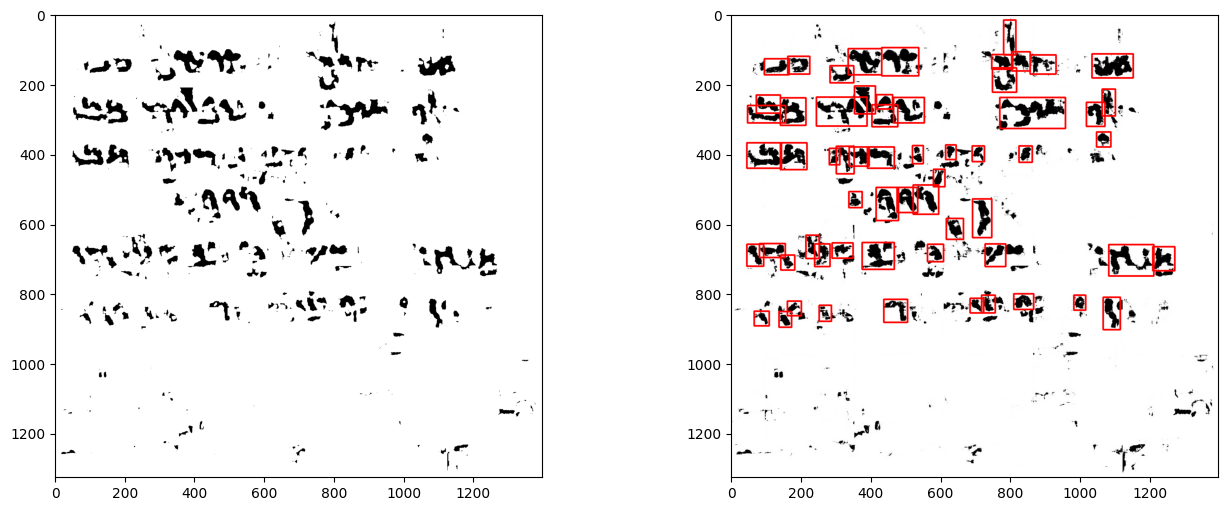

<Figure size 700x700 with 0 Axes>

(2360, 2017)
(2360, 2017)


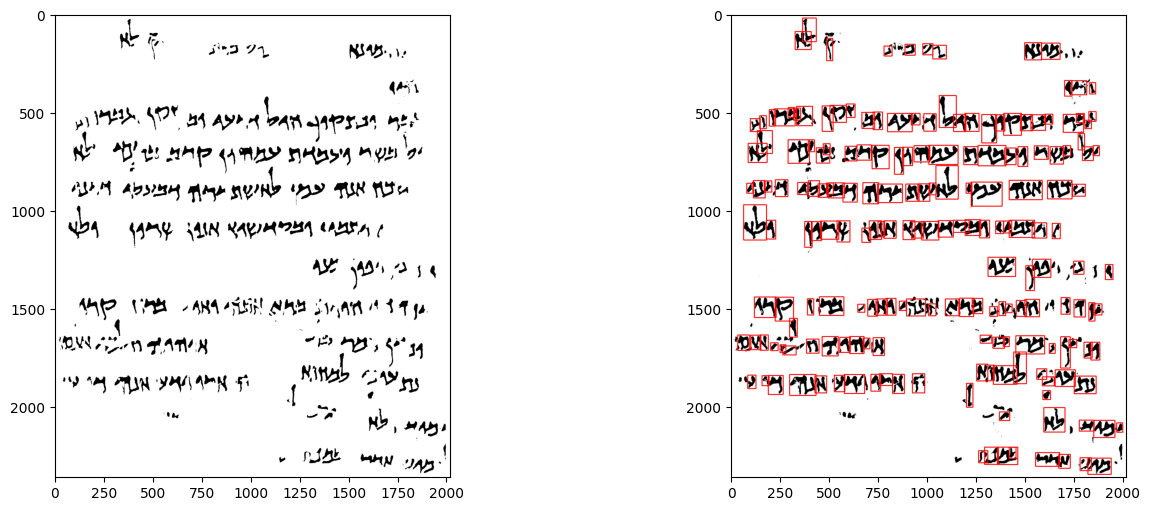

<Figure size 700x700 with 0 Axes>

(2065, 2722)
(2065, 2722)


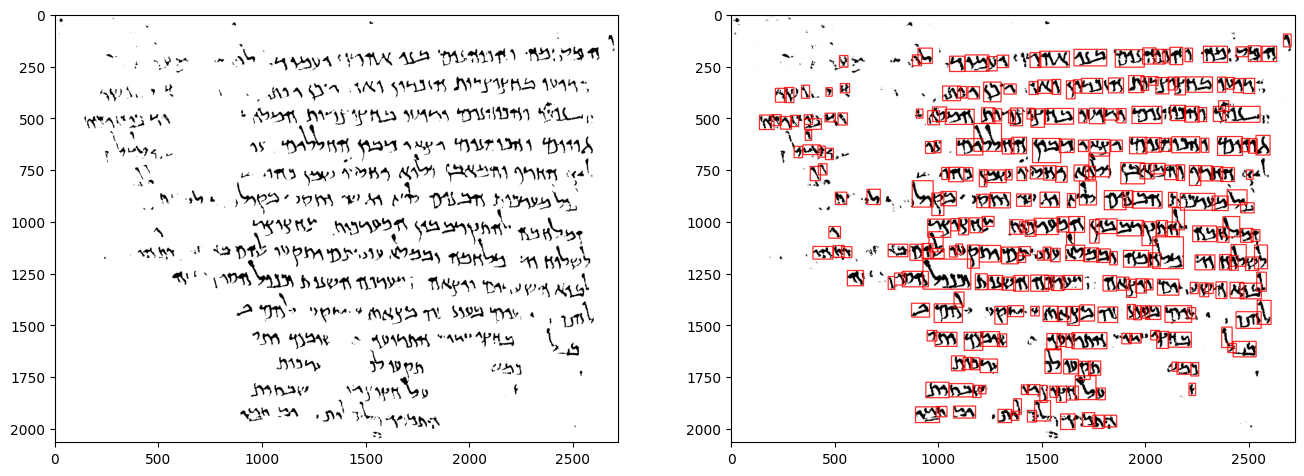

<Figure size 700x700 with 0 Axes>

KeyboardInterrupt: 

In [123]:
from data_management.augmentation.commonAug import whitespaceRemover
import cv2
import matplotlib.pyplot as plt

for filename in binaryFiles[:]:
    

    img_path = os.path.join(sourceFolder, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #Read the img
    img = whitespaceRemover(img=img, padding=20)

    BBs, BB_centers, processed_img = segment_dss_page_PLAY(img)

    drawing_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for (x1,y1,x2,y2) in BBs:
        drawing_img = cv2.rectangle(drawing_img, (x1,y1), (x2,y2), color = (255,0,0), thickness=4)

    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    plt.figure(figsize=(7,7))
    ax1.imshow(cv2.bitwise_not(processed_img), cmap='gray')
    ax2.imshow(drawing_img, cmap='gray')
    plt.show()